# MLA decoding kernel of AITER library to accelerate LLM inference

# Introduction: When Performance Hits a Wall
Imagine you’re deploying a large language model like DeepSeek-V3/R1 on AMD Instinct™ GPUs when suddenly—the Multi-Latent Attention (MLA) in the decoding phase becomes a performance bottleneck. Every token generation feels sluggish, and latency keeps accumulating, degrading user experience. This is where the AMD AITER library comes to the rescue, dramatically accelerating the MLA decode attention kernel to breathe new life into your model.

AITER is an AMD high-performance operator library, meticulously optimized for AI workloads on AMD Instinct GPUs. It becomes indispensable when:

- Operator performance falls far short of theoretical potential

- Specific operators become inference bottlenecks

- You need architecture-specific optimizations for AMD Instinct GPUs

This tutorial will guide you step-by-step through integrating AITER’s MLA decode attention kernel to supercharge LLM inference on AMD Instinct GPUs like the MI300X. The kernel will be accelerated by 5.1x~6.6x with different context length compared to native pytorch implementations. Let's start by going through the MLA decode attention kernel!

**TIPS**: What's exciting is that kernels in AITER library are already integrated into popular LLM inference frameworks like vLLM and SGLang, which means you can also get achieve significant performance gains from AITER library on AMD Instinct GPUs through these frameworks!

# Prerequisites: Setting Up Your Acceleration Environment
As this tutorial was developed and tested using the following setup, we recommend the same set up to reproduce the same model acceleration with AMD Instinct GPUs.
## Operating System 
* **Ubuntu 22.04** – A stable, well-validated release
## Hardware 
* **AMD Instinct™ GPUs** – Ensure your device supports ROCm™ software and meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).
## Software 
* ROCm 6.3.1 – The foundation for AMD GPU computing
Install and verify ROCm by following the ROCm install guide. After installation, confirm it using:
```
rocm-smi
```
This command lists available AMD GPUs and their status:
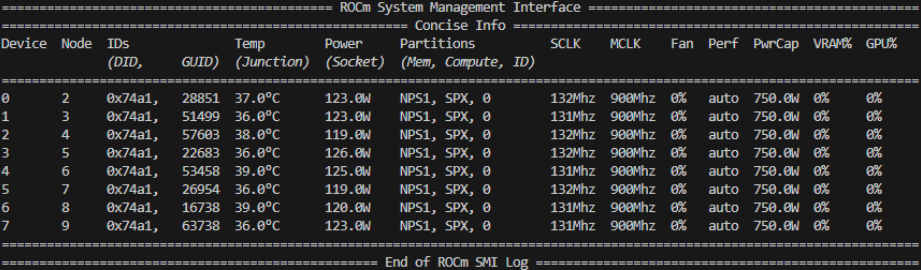
* **Docker** – For containerized deployment 
Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

**TIPS**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:
```
sudo usermod -aG docker $USER
newgrp docker
```
Test docker with: 
```
docker run hello-world
```
# Quick Start: Two Installation steps
## Step 1: Launch a ROCm PyTorch Docker container

Our turnkey solution with pre-configured dependencies:

```
docker run -it --rm \
  --network=host \
  --device=/dev/kfd \
  --device=/dev/dri \
  --group-add=video \
  --ipc=host \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size 8G \
  -v $(pwd):/workspace \
  -w /workspace \
  rocm/pytorch:latest
```
**TIPS**: This mounts your current directory to /workspace in the container for easy file access and enables you do any work in this docker container including install AITER manually and get started with following interesting hands-on practical examples. 

## Step 2: Launch an interactive Jupyter Notebooks in the container
Launch JupyterLab inside the container:
```
pip install jupyter
```
Start the Jupyter server:
```
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```
**TIPS**: If port 8888 is occupied, specify alternatives like --port=8890. The rest of this tutorial can run as interactive blocks in your Jupyter notebook after you upload this tutorial to your server.

## Step 3: Install AITER library Manually

AITER is a fastly updating library, there are many cutting-edge features that you can enjoy by:

In [ ]:
%%bash
git clone --recursive https://github.com/ROCm/aiter.git
cd aiter
python3 setup.py develop
export PYTHONPATH=$PYTHONPATH:/workspace/aiter

If running in your environment, don't forget to set the `PTHONPATH`accordingly.

# Understanding the MLA Decode attention Kernel

You can find the MLA decoding attention kernel definition in [source code of aiter](https://github.com/ROCm/aiter/blob/main/aiter/mla.py#L114C1-L126C3), which requires 8 minimum inputs and 3 optional inputs. Let’s examine the mla_decode_fwd parameters:
```
def mla_decode_fwd(  
    q,                   # [batch_size, num_heads, kv_lora_rank + qk_rope_dim]  
    kv_buffer,           # [num_pages, page_size, num_heads_kv, qk_head_dim]  
    o,                   # Output buffer [batch_size, num_heads, kv_lora_rank]  
    qo_indptr,           # Query sequence pointer [batch_size + 1]  
    kv_indptr,           # KV sequence pointer [batch_size + 1]  
    kv_indices,          # KV indices [kv_indptr[-1]]  
    kv_last_page_lens,   # Last page sizes [batch_size]  
    max_seqlen_q,        # Maximum query sequence length  
    sm_scale=None,       # Scaling factor (default: 1.0/sqrt(qk_head_dim))  
    logit_cap=0.0,       # (Under development)  
    num_kv_splits=None,  # KV splits (auto-determined)  
): 
```
Each parameter has specific shape requirements and proper configuration is key to optimal performance:
* **q**: torch.tensor type, query tensor, whose shape requirements is like` [batch_size, num_heads, kv_lora_rank + qk_rope_dim]`
* **kv buffer**: torch.tensor type,total kv cache tensor, whose shape requirements is like `[num_pages, page_size, num_heads_kv, qk_head_dim]`, where num_heads_kv is always 1 in the decode phase, and num_pages and page_size jointly represent the pageable kv cache. when page_size = 1, the kv cache is the original representation, which will waste a lot of GPU memory.
* **o**: torch.tensor type, buffer for output, the mla_decode_fwd function will put the result into o, whose shape requirements is like `[batch_size, num_heads, kv_lora_rank]`
* **qo_indptr**: torch.tensor type, pointer that point to start address of each query and output sequence, whose shape requirements is like `[batch_size + 1]`. When sequence length of each sequence is different in a batch, the qo_indptr is used to record this and will be useful to take each sequence correctly
* **kv_indptr:** torch.tensor type, pointer that point to start address of each context/kv sequence, whose shape requirements is like `[batch_size + 1]`. each query sequence is different in a batch, and their sequence of answer are also different, so the context/kv sequence length are different, the kv_indptr is used to record this and will be useful to take each context/kv of query sequence  correctly
* **kv_indices:** torch.tensor type, concrete kv start indices of each sequence, whose shape requirements is like `[kv_indptr[-1]]`
* **kv_last_page_lens:** torch.tensor type, represent the last page size of each sequence, whose shape requirements is like `[batch_size]`
* **max_seqlen_q:** torch.tensor type, the max sequence length across all the queries in this batch
* **sm_scale:** scalar type, equal to 1.0 / (qk_head_dim**0.5), which represent the denominator in the scale dot product attention formula
* **logit_cap:** you can ignore it. As [annotation](https://github.com/ROCm/aiter/blob/main/aiter/mla.py#L128) beside the code said, the features about logit_cap are working in progress
* **num_kv_splits:** scalar type, represent how many GPU work groups or blocks you would like to allocate to handle kv, and you can ignore it, since the code will determine it by heuristic algorithm

# Hands-On: A Practical Example

Ready to see the magic happen? Let's jump right into a practical example that will have your MLA decoding attention running at lightning speed on MI300X. This step-by-step walkthrough is designed to get you from zero to hero in minutes!

## Setting the Stage

First, let's prepare our backstage - the computing device. We'll aim for the star performer, our AMD MI300X GPU, with CPU standing by as the understudy:

In [ ]:
import os
import sys

# Change working directory to the repo
os.chdir("./aiter")  # relative path from the notebook location

# Add current directory (aiter repo root) to Python path
sys.path.insert(0, os.getcwd())

import torch
from aiter.mla import mla_decode_fwd 

# Let's get our hardware ready for the show!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"All systems go! Running on: {device}")

## Prepare the actors(Our Tensors)¶
Now, let's cast our tensors for this performance. We'll configure:

- A batch of 128 sequences, aka. batch_size = 128

- 4096-token KV cache (the memory of our model), aka. kv_cache_seqlen = 4096

- Single-query decoding, aka. q_seqlen = 1

In [ ]:
# Our performance parameters
batch_size = 128       # How many sequences we're processing
kv_cache_seqlen = 4096 # How far back our model can remember
q_seqlen = 1           # Decoding one token at a time

# Initialize our pointer arrays
qo_indptr = torch.zeros(batch_size + 1, dtype=torch.int, device=device)
kv_indptr = torch.zeros(batch_size + 1, dtype=torch.int, device=device)

# Fill with sequence lengths (simple case: all equal)
seq_lens_qo = torch.full((batch_size,), q_seqlen, dtype=torch.int, device=device)
seq_lens_kv = torch.full((batch_size,), kv_cache_seqlen, dtype=torch.int, device=device)

As you can see, we first declare two buffers for qo_indptr and kv_indptr and fill seq_lens_qo and seq_lens_kv with q_seqlen = 1 and kv_cache_seqlen = 4096 since we assumed each sequence has same q seqlen and kv cache seqlen for simplicity

Then, we further fill the kv_indptr and qo_indptr by cumsum the seqlen of qkv to get the actual sequence length of each sequence by the latter value substracting the former value, which is secret sauce of efficient attention lies in:

In [ ]:
# Calculate cumulative lengths - this tells us where each sequence starts
kv_indptr[1:] = torch.cumsum(seq_lens_kv, dim=0)  # KV memory layout
qo_indptr[1:] = torch.cumsum(seq_lens_qo, dim=0) # Query/output layout

# For example: kv_indptr = [0,5,11,18] means:
# Sequence 0: positions 0-4 (length 5)
# Sequence 1: positions 5-10 (length 6)
# Sequence 2: positions 11-17 (length 7)

Now, let's prepare our key-value cache - think of this as the model's working memory, we initialize the concrete kv start indices of each sequence and the kv last page lens of each sequence, for simplicity, we define the page_size = 1, so the kv last page lens for each sequence are all 1. And you can see the maximum value for kv indices is 2097152, which originated by batch_size * 16384 = 128 * 16384, that means for batch_size=128, we can generate up to 16384 tokens for each sequence in this example.

In [ ]:
kv_indices = torch.randint(0, 2097152, (kv_indptr[-1].item(),), dtype=torch.int, device=device)
kv_last_page_lens = torch.ones(batch_size, dtype=torch.int, device=device)

Time to introduce our main inputs - the query tensor and output buffer, which are `q`, `kv buffer` and `o`:

In [ ]:
num_heads = 128        # Number of attention heads
q_head_dim = 128       # Dimension per head
kv_lora_rank = 512     # LoRA rank for KV
qk_rope_head_dim = 64  # Rotary embedding dimension

# The query tensor - what we're asking our model
q = torch.randn(
    (batch_size * q_seqlen, num_heads, kv_lora_rank + qk_rope_head_dim),
    dtype=torch.bfloat16, device=device
)
num_heads_kv = 1
page_size = 1
q_head_dim = 128
# Our KV cache - the model's knowledge bank
kv_buffer = torch.randn(
    (2097152, page_size, num_heads_kv, kv_lora_rank + qk_rope_head_dim), 
    dtype=torch.bfloat16, device=device
)

# The output buffer - where the magic will happen
o = torch.empty(
    (batch_size * q_seqlen, num_heads, kv_lora_rank), 
    dtype=torch.bfloat16, device=device
).fill_(-1)

**TIPS**: you don't have to define these buffers, however, ensure the shape is the same as me is OK in your program. 

## Showtime: Launching the Kernel

With everything set, let's fire up our optimized MLA decode attention kernel!

In [ ]:
mla_decode_fwd(
        q,
        kv_buffer,
        o,
        qo_indptr,
        kv_indptr,
        kv_indices,
        kv_last_page_lens,
        1,
        sm_scale= 1.0 / (q_head_dim**0.5)
    )

Let's see what we got!

In [ ]:
print(o)

and its shape is

In [ ]:
print(o.shape)

# Summary

With the attention computation now turbocharged, these optimized results are ready to flow seamlessly into your model's next layer - keeping your entire inference pipeline running at maximum velocity!

But don't just take our word for it. Our rigorous benchmarking tells the real ability of the kernel:

**Benchmark Highlights:**

- Evaluated multiple context lengths (512-4096 tokens)
- Tested with fixed batch sizes (128)
- Compared different MLA algorithm implementations
- **Result:** Consistent 5.1x to 6.6x speedup over native PyTorch implementations

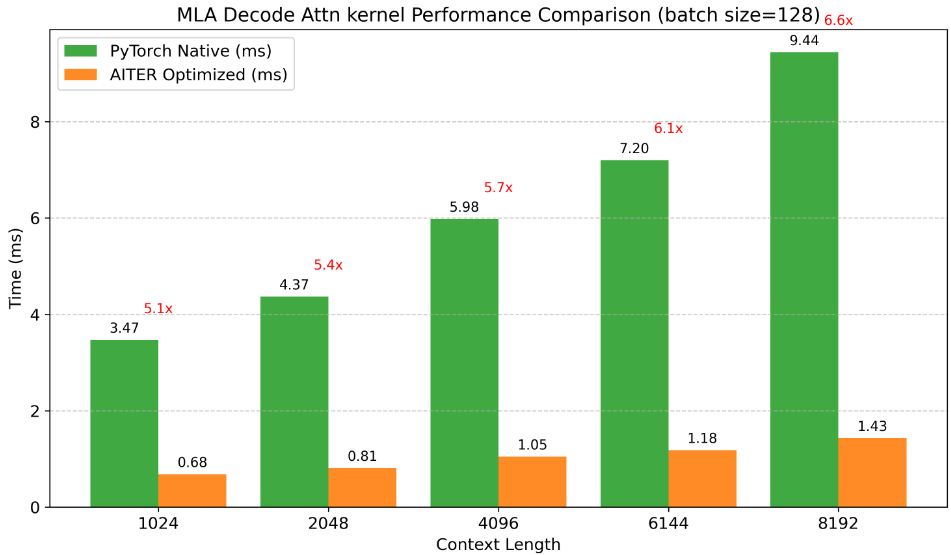

Imagine what these gains could mean for your application:
- Reduce latency for real-time applications
- Increase throughput for batch processing
- Lower compute costs across the board

Ready to take the next step? Dive deeper into AITER's capabilities:

🔗 Explore the [AITER github repository](https://github.com/ROCm/aiter). 

💡 Check out additional optimization examples

🌟 Star the repo to stay updated on new features
